In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_file.csv')
total_n = len(df)
df.head()

,Alert,Date,Time,Lat,Long,Vehicle,Speed,Datetime,Timestamp,Geohash
0,cas_ldw,2022-05-01,00:00:06,14.196872,77.631213,3829.0,58,2022-05-01 00:00:06,1651363206,tdx0y83q
1,cas_ldw,2022-05-01,00:00:07,16.511887,80.746034,8111.0,56,2022-05-01 00:00:07,1651363207,tfcmvmvk
2,cas_ldw,2022-05-01,00:00:11,17.908537,78.464064,1153.0,74,2022-05-01 00:00:11,1651363211,tepvckpu
3,cas_ldw,2022-05-01,00:00:11,13.152203,77.620431,7103.0,72,2022-05-01 00:00:11,1651363211,tdr4y633
4,cas_ldw,2022-05-01,00:00:15,16.512134,80.748452,8111.0,57,2022-05-01 00:00:15,1651363215,tfcmvmzn


In [3]:
# Number of samples to take from each stratum (0.5% of total)
n_samples_per_stratum = int(total_n * 0.005)

stratified_sample = pd.DataFrame()

for alert_type in df['Alert'].unique():
    stratum = df[df['Alert'] == alert_type]
    stratum_sample = stratum.sample(n=min(n_samples_per_stratum, len(stratum)), random_state=1)
    stratified_sample = pd.concat([stratified_sample, stratum_sample])

stratified_sample.head(), stratified_sample['Alert'].value_counts(), len(stratified_sample)

(           Alert        Date      Time        Lat       Long  Vehicle  Speed  \
 786210   cas_ldw  2022-05-20  01:03:59  16.707057  80.352237   6152.0     65   
 1300491  cas_ldw  2022-05-29  00:55:50  17.078202  79.798202   7819.0     70   
 1407012  cas_ldw  2022-05-30  21:50:28  16.920730  80.089397   1113.0     78   
 1348993  cas_ldw  2022-05-29  22:16:13  16.691493  77.929545   6809.0     68   
 725944   cas_ldw  2022-05-18  23:39:06  17.162551  79.324757   8111.0     58   
 
                     Datetime   Timestamp   Geohash  
 786210   2022-05-20 01:03:59  1653008639  tfcph3qt  
 1300491  2022-05-29 00:55:50  1653785750  tg09pugr  
 1407012  2022-05-30 21:50:28  1653947428  tg0bq2r6  
 1348993  2022-05-29 22:16:13  1653862573  tdzqvqdd  
 725944   2022-05-18 23:39:06  1652917146  tg03th6e  ,
 Alert
 cas_ldw           9229
 cas_hmw           9229
 hard_brake        9229
 cas_pcw           9229
 cas_fcw           9229
 dms_distracted     328
 dms_noseatbelt      71
 dms_asleep 

In [4]:
# plt.figure(figsize=(10, 6))
# sns.countplot(data=stratified_sample, x='Alert', order=stratified_sample['Alert'].value_counts().index)
# plt.title('Frequency Distribution of Alerts')
# plt.xlabel('Alert Type')
# plt.ylabel('Frequency')
# plt.show()

speed_stats = stratified_sample.groupby('Alert')['Speed'].describe()

# stratified_sample['Hour'] = np.random.choice(range(24), len(stratified_sample))

# plt.figure(figsize=(10, 6))
# sns.countplot(data=stratified_sample, x='Hour', hue='Alert')
# plt.title('Alert Frequencies by Time of Day')
# plt.xlabel('Hour of Day')
# plt.ylabel('Frequency')
# plt.show()

speed_stats

,count,mean,std,min,25%,50%,75%,max
Alert,,,,,,,,
cas_fcw,9229.0,42.077582,13.161843,0.0,33.0,37.0,46.0,99.0
cas_hmw,9229.0,42.780258,13.204259,0.0,32.0,39.0,51.0,99.0
cas_ldw,9229.0,70.081591,10.396827,0.0,62.0,70.0,77.0,100.0
cas_pcw,9229.0,19.641781,8.919642,0.0,13.0,18.0,25.0,75.0
dms_asleep,43.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
dms_distracted,328.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
dms_drowsy,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
dms_noseatbelt,71.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
dms_onphone,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


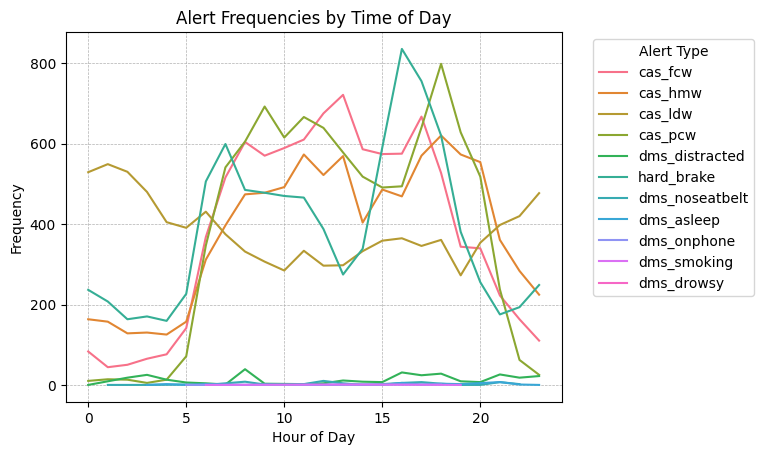

In [5]:
stratified_sample['Datetime'] = pd.to_datetime(stratified_sample['Datetime'])

stratified_sample['Hour'] = stratified_sample['Datetime'].dt.hour
stratified_sample['Weekday'] = stratified_sample['Datetime'].dt.weekday  # 0 is Monday, 6 is Sunday

alert_by_hour = stratified_sample.groupby(['Hour', 'Alert']).size().reset_index(name='Frequency')

sns.lineplot(data=alert_by_hour, x='Hour', y='Frequency', hue='Alert')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Alert Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Alert Frequencies by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

In [6]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[stratified_sample['Lat'].mean(), stratified_sample['Long'].mean()], zoom_start=5)

for alert_type in stratified_sample['Alert'].unique():

    alert_data = stratified_sample[stratified_sample['Alert'] == alert_type]
    
    heat_data = [[row['Lat'], row['Long']] for index, row in alert_data.iterrows()]
    
    HeatMap(heat_data).add_to(m)

m.save("alert_heatmaps.html")
m

In [7]:
# # 2. Geoclustering: Applying clustering algorithms like DBSCAN to spatial coordinates to identify hotspots

# from sklearn.cluster import DBSCAN

# # Prepare data: Selecting only the Lat and Long columns
# geo_data = stratified_sample[['Lat', 'Long']]

# # Apply DBSCAN clustering
# dbscan = DBSCAN(eps=10, min_samples=5)  # eps and min_samples are hyperparameters and should be tuned for real data
# clusters = dbscan.fit_predict(geo_data)

# # Add cluster labels to the data
# stratified_sample['Cluster'] = clusters

# # Plot the clustered data for 'cas_ldw' alert type
# cas_ldw_data = stratified_sample[stratified_sample['Alert'] == 'cas_ldw']

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=cas_ldw_data, x='Long', y='Lat', hue='Cluster', palette='viridis', s=60)
# plt.title('Geospatial Clusters for CAS LDW Alerts')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Move the legend outside the plot
# plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

In [8]:
# from sklearn.cluster import DBSCAN
# from collections import Counter

# # Initial round of DBSCAN for data aggregation
# # Prepare data: Selecting only the Lat and Long columns
# geo_data_aggregate = stratified_sample[['Lat', 'Long']]

# # Use a large eps value to aggregate nearby points into single points
# dbscan_aggregate = DBSCAN(eps=0.5, min_samples=1)  # Large eps, min_samples set to 1 for aggregation
# aggregation_clusters = dbscan_aggregate.fit_predict(geo_data_aggregate)

# # Count the number of points in each cluster and use it as a weight
# cluster_counts = Counter(aggregation_clusters)
# stratified_sample['Weight'] = [cluster_counts[cluster] for cluster in aggregation_clusters]

# # Your existing code for refined clustering starts here
# # Prepare data: Selecting only the Lat and Long columns
# geo_data = stratified_sample[['Lat', 'Long']]

# # Apply DBSCAN clustering
# dbscan = DBSCAN(eps=10, min_samples=5)  # eps and min_samples are hyperparameters and should be tuned
# clusters = dbscan.fit_predict(geo_data, sample_weight=stratified_sample['Weight'])  # Using weights

# # Add cluster labels to the data
# stratified_sample['Cluster'] = clusters

# # Plot the clustered data for 'cas_ldw' alert type
# cas_ldw_data = stratified_sample[stratified_sample['Alert'] == 'cas_ldw']

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=cas_ldw_data, x='Long', y='Lat', hue='Cluster', palette='viridis', s=60)
# plt.title('Geospatial Clusters for CAS LDW Alerts')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Move the legend outside the plot
# plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

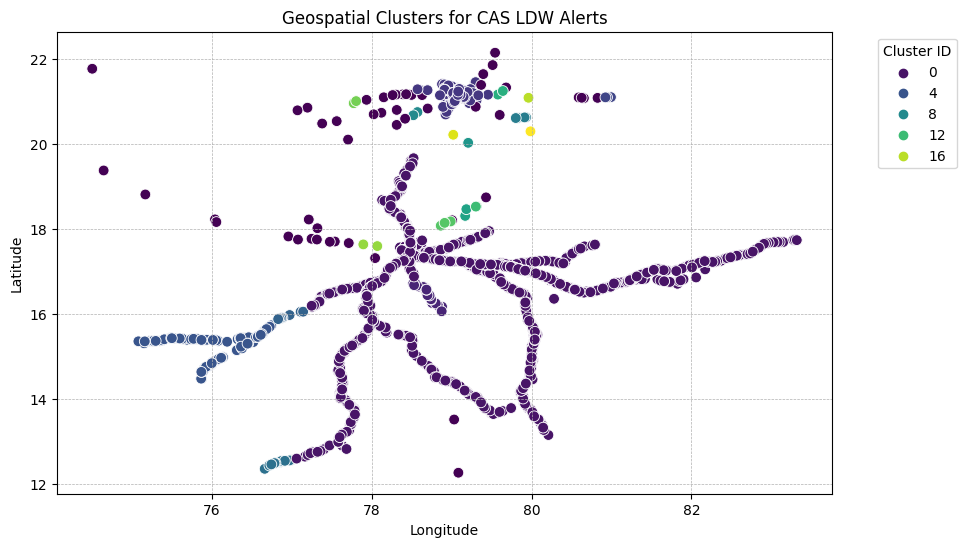

In [9]:
from sklearn.cluster import DBSCAN

def lat_long_to_cartesian(lat, lon):
    earth_radius = 6371  # in km
    lat, lon = np.radians(lat), np.radians(lon)
    x = earth_radius * np.cos(lat) * np.cos(lon)
    y = earth_radius * np.cos(lat) * np.sin(lon)
    z = earth_radius * np.sin(lat)
    return x, y, z

stratified_sample['X'], stratified_sample['Y'], stratified_sample['Z'] = lat_long_to_cartesian(
    stratified_sample['Lat'], stratified_sample['Long'])

geo_data_cartesian = stratified_sample[['X', 'Y', 'Z']]

dbscan = DBSCAN(eps=10, min_samples=5)
clusters = dbscan.fit_predict(geo_data_cartesian)

stratified_sample['Cluster'] = clusters
cas_ldw_data = stratified_sample[stratified_sample['Alert'] == 'cas_ldw']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cas_ldw_data, x='Long', y='Lat', hue='Cluster', palette='viridis', s=60)
plt.title('Geospatial Clusters for CAS LDW Alerts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [10]:
# from sklearn.metrics import pairwise_distances
# from sklearn.cluster import DBSCAN

# # Calculate the haversine distance matrix
# def haversine_distance_matrix(X):
#     lat, lon = X[:, 0], X[:, 1]
#     lat, lon = np.radians(lat), np.radians(lon)
#     a = np.sin((lat[:, None] - lat[None, :]) / 2.0) ** 2 + \
#         np.cos(lat[:, None]) * np.cos(lat[None, :]) * \
#         np.sin((lon[:, None] - lon[None, :]) / 2.0) ** 2
#     c = 2 * np.arcsin(np.sqrt(a))
#     earth_radius_km = 6371
#     return earth_radius_km * c

# # Prepare the data: only Lat and Long columns
# geo_data = stratified_sample[['Lat', 'Long']].values

# # Compute the distance matrix
# distance_matrix = haversine_distance_matrix(geo_data)

# # Apply DBSCAN clustering with precomputed distance matrix
# dbscan = DBSCAN(eps=10, min_samples=5, metric='precomputed')  
# clusters = dbscan.fit_predict(distance_matrix)

# # Add cluster labels to the data
# stratified_sample['Cluster'] = clusters

# # Plot the clustered data for 'cas_ldw' alert type
# cas_ldw_data = stratified_sample[stratified_sample['Alert'] == 'cas_ldw']

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=cas_ldw_data, x='Long', y='Lat', hue='Cluster', palette='viridis', s=60)
# plt.title('Geospatial Clusters for CAS LDW Alerts')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Move the legend outside the plot
# plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

In [11]:
from collections import Counter

cluster_counts = Counter(cas_ldw_data['Cluster'])

if -1 in cluster_counts:
    del cluster_counts[-1]

top_clusters = sorted(cluster_counts, key=cluster_counts.get, reverse=True)[:5]

top_clusters_data = cas_ldw_data[cas_ldw_data['Cluster'].isin(top_clusters)]

centroids = top_clusters_data.groupby('Cluster')[['Lat', 'Long']].mean().reset_index()

print("Top 5 Most Dense Clusters and Their Centroids:")
print(centroids)

Top 5 Most Dense Clusters and Their Centroids:
   Cluster        Lat       Long
0        0  16.668799  79.043838
1        1  16.475599  78.692883
2        2  21.141525  79.063696
3        4  15.266857  76.045770
4        6  12.501443  76.839478


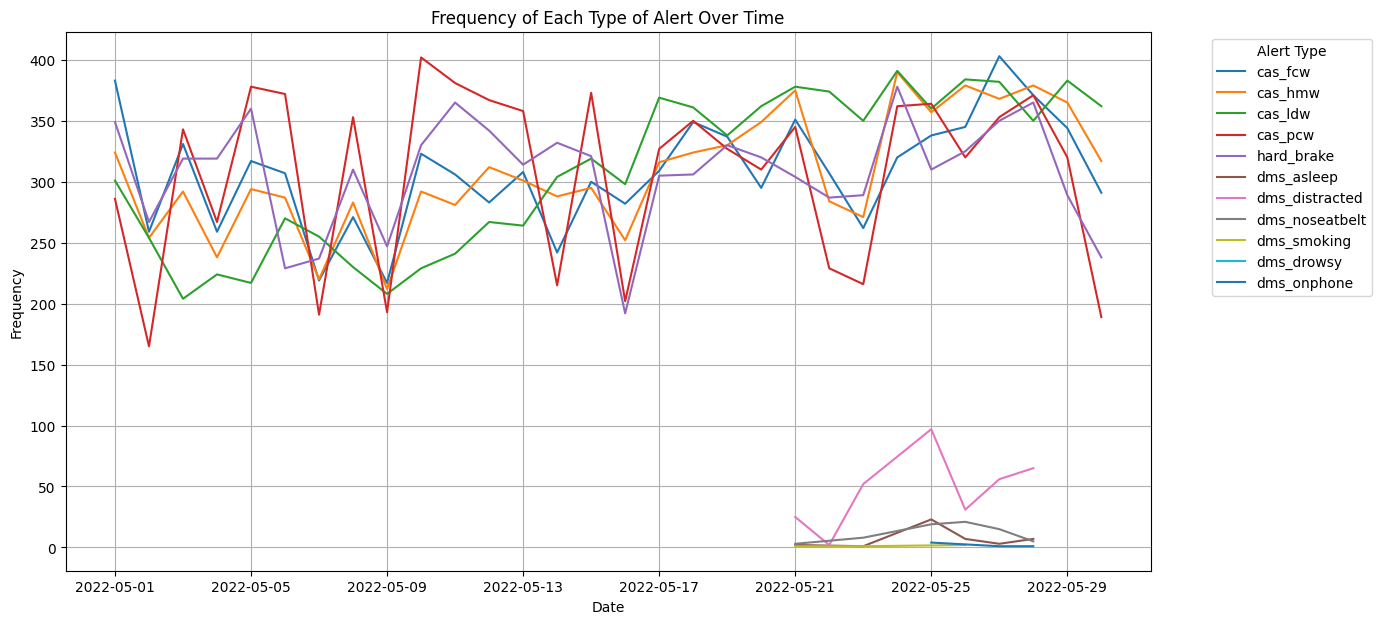

In [12]:
stratified_sample['Datetime'] = pd.to_datetime(stratified_sample['Datetime'])

alert_counts_per_day = stratified_sample.groupby([stratified_sample['Datetime'].dt.date, 'Alert']).size().reset_index(name='Frequency')

plt.figure(figsize=(14, 7))
for alert_type in alert_counts_per_day['Alert'].unique():
    subset = alert_counts_per_day[alert_counts_per_day['Alert'] == alert_type]
    plt.plot(subset['Datetime'], subset['Frequency'], label=alert_type)

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of Each Type of Alert Over Time')
plt.legend(title='Alert Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

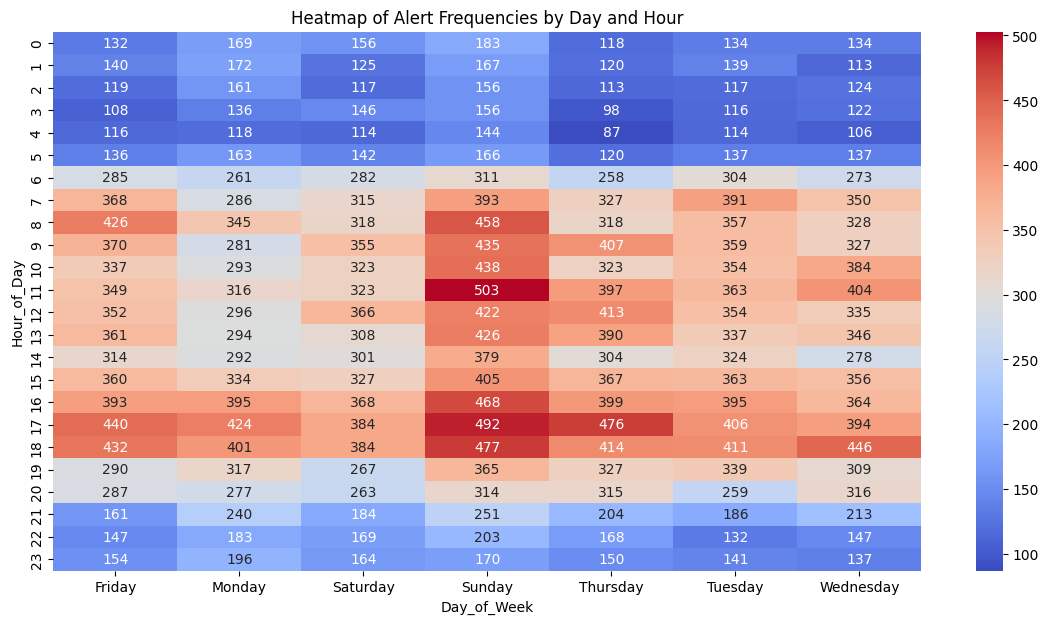

In [13]:
stratified_sample['Day_of_Week'] = stratified_sample['Datetime'].dt.day_name()
stratified_sample['Hour_of_Day'] = stratified_sample['Datetime'].dt.hour

alert_counts_by_time = stratified_sample.groupby(['Day_of_Week', 'Hour_of_Day', 'Alert']).size().reset_index(name='Frequency')

plt.figure(figsize=(14, 7))
pivot_data = alert_counts_by_time.pivot_table(values='Frequency', index='Hour_of_Day', columns='Day_of_Week', aggfunc='sum', fill_value=0)
sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt='d')
plt.title('Heatmap of Alert Frequencies by Day and Hour')
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

print("sample null check:")
print(stratified_sample.isnull().sum())

alert_encoded = pd.get_dummies(stratified_sample['Alert'])
day_of_week_encoded = pd.get_dummies(stratified_sample['Day_of_Week'])
hour_of_day_normalized = stratified_sample['Hour_of_Day'] / 23.0

day_of_week_encoded.reset_index(drop=True, inplace=True)
hour_of_day_normalized.reset_index(drop=True, inplace=True)
alert_encoded.reset_index(drop=True, inplace=True)

if all([day_of_week_encoded.index.equals(hour_of_day_normalized.index),
        day_of_week_encoded.index.equals(alert_encoded.index)]):
    X = pd.concat([day_of_week_encoded, 
                   pd.DataFrame(hour_of_day_normalized, columns=['Hour_of_Day']), 
                   alert_encoded], 
                  axis=1)
else:
    print("Indices are not aligned. Further investigation is needed.")

iso_forest = IsolationForest(n_estimators=100, contamination=0.05)

stratified_sample['Anomaly_IsolationForest'] = iso_forest.fit_predict(X)

anomalies_isolation_forest = stratified_sample[stratified_sample['Anomaly_IsolationForest'] == -1]
# print(anomalies_isolation_forest)

sample null check:


d:\anaconda3\envs\torch\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [15]:
anomalies_isolation_forest.describe()

,Lat,Long,Vehicle,Speed,Datetime,Timestamp,Hour,Weekday,X,Y,Z,Cluster,Hour_of_Day,Anomaly_IsolationForest
count,2312.000000,2312.000000,2312.000000,2312.000000,2312,2.312000e+03,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000,2312.0
mean,16.713029,78.936455,6143.982266,38.625865,2022-05-19 08:03:53.182093568,1.652947e+09,7.546280,3.407007,1170.539679,5984.967021,1831.440516,0.231401,7.546280,-1.0
min,12.265339,74.654950,114.000000,0.000000,2022-05-01 00:01:31,1.651363e+09,0.000000,0.000000,714.702963,5726.791014,1353.450685,-1.000000,0.000000,-1.0
25%,16.145027,78.012623,3829.000000,0.000000,2022-05-14 00:15:15.500000,1.652487e+09,0.000000,2.000000,1078.345098,5964.085251,1771.581461,0.000000,0.000000,-1.0
50%,16.930213,78.765277,7107.500000,44.000000,2022-05-21 01:11:42,1.653096e+09,1.000000,4.000000,1186.750978,5987.196136,1855.277864,0.000000,1.000000,-1.0
75%,17.295828,79.835755,8877.000000,67.000000,2022-05-26 22:23:39.500000,1.653604e+09,20.000000,5.000000,1272.292337,6018.558771,1894.132426,0.000000,20.000000,-1.0
max,21.384303,83.235802,9879.000000,99.000000,2022-05-30 05:52:41,1.653890e+09,23.000000,6.000000,1571.513579,6112.943073,2323.004816,18.000000,23.000000,-1.0
std,1.596515,1.109771,2863.311910,31.597009,NaN,6.968385e+05,9.512593,1.916474,119.517164,49.465205,169.592961,0.993967,9.512593,0.0


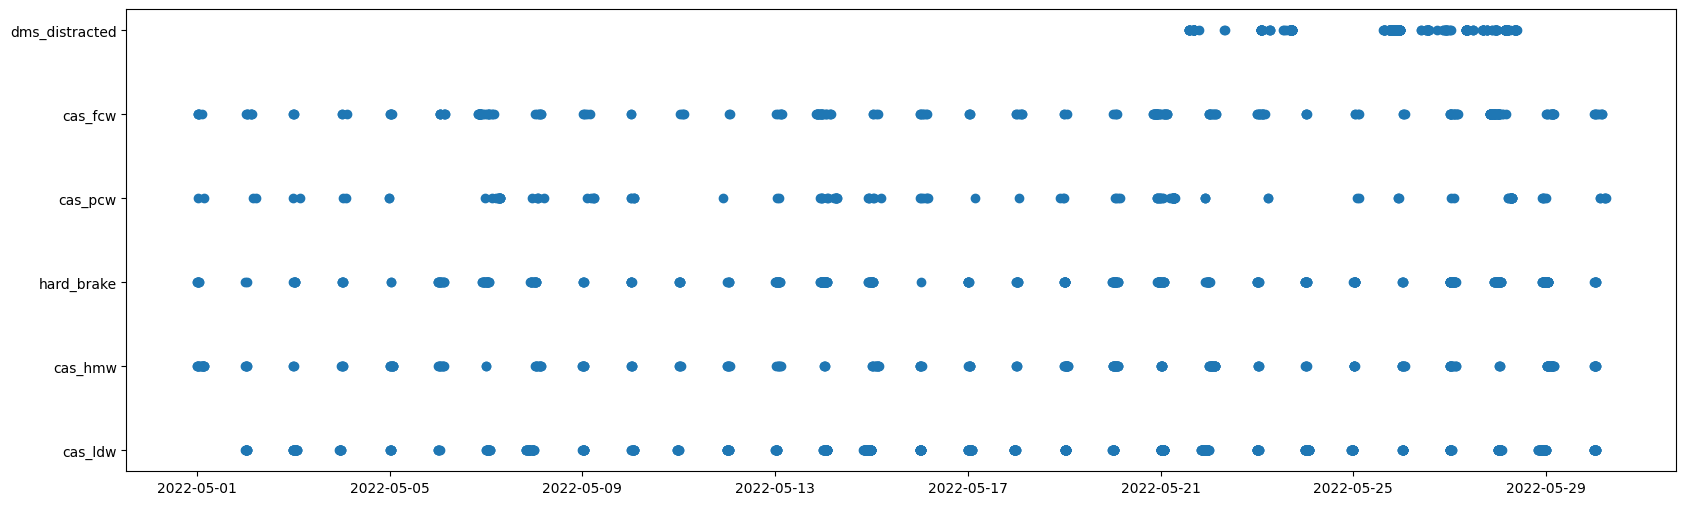

In [16]:
plt.figure(figsize=(20, 6))
plt.scatter(anomalies_isolation_forest['Datetime'], anomalies_isolation_forest['Alert'])

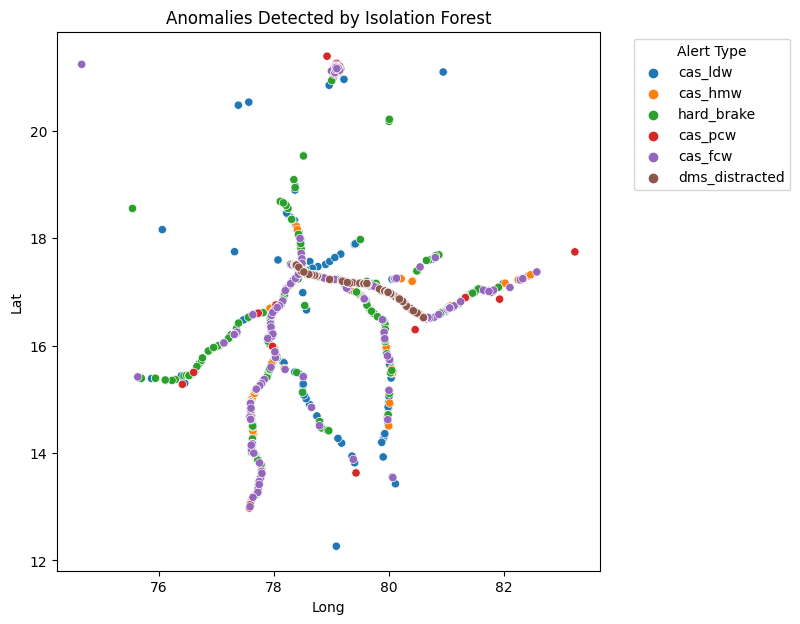

In [17]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=anomalies_isolation_forest, x='Long', y='Lat', hue='Alert')
plt.legend(title='Alert Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Anomalies Detected by Isolation Forest')
plt.show()

In [18]:
anomalies_isolation_forest['Alert'].value_counts()

Alert
cas_ldw           808
hard_brake        443
dms_distracted    328
cas_fcw           302
cas_hmw           287
cas_pcw           144
Name: count, dtype: int64

In [19]:
geo_data = stratified_sample[['Lat', 'Long']]

dbscan = DBSCAN(eps=0.5, min_samples=5)
stratified_sample['Cluster_DBSCAN'] = dbscan.fit_predict(geo_data)

stratified_sample['Spatial_Anomaly_DBSCAN'] = (stratified_sample['Cluster_DBSCAN'] == -1)

anomalies_dbscan = stratified_sample[stratified_sample['Spatial_Anomaly_DBSCAN']]

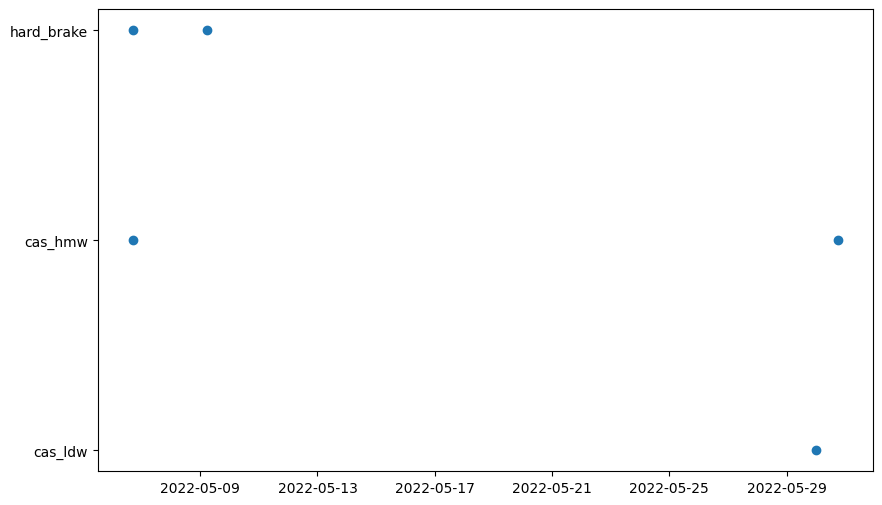

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(anomalies_dbscan['Datetime'], anomalies_dbscan['Alert'])

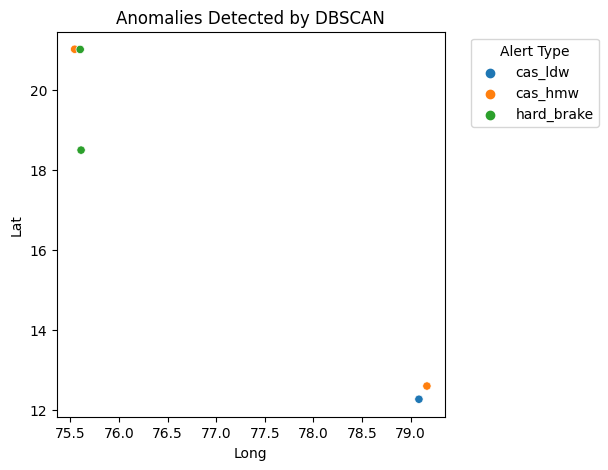

In [21]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=anomalies_dbscan, x='Long', y='Lat', hue='Alert')
plt.legend(title='Alert Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Anomalies Detected by DBSCAN')
plt.show()

In [22]:
anomalies_dbscan['Alert'].value_counts()

Alert
cas_hmw       2
hard_brake    2
cas_ldw       1
Name: count, dtype: int64